# **1. Overview**

## Description

**Why This Matters**

Accurate sales forecasts are crucial for planning process, supply chain processes, delivery logistics and inventory management. By optimizing forecasts, we can minimize waste and streamline operations, making our e-grocery services more sustainable and efficient.

**Your Impact**

Your participation in this challenge will directly contribute to Rohlik mission of sustainable and efficient e-grocery delivery. Your insights will help us enhance customer service and achieve a greener future.

We are relaunching the Challenge with prizes.

Rohlik Group, a leading European e-grocery innovator, is revolutionising the food retail industry. We operate across 11 warehouses in Czech Republic, Germany, Austria, Hungary, and Romania.

We are now transitioning from the Rohlik Orders Forecasting Challenge to the Rohlik Sales Forecasting Challenge, as we continue with our set of challenges. This challenge focuses on predicting the sales of each selected warehouse inventory for next 14 days using historical sales data.

## Evaluation

Submissions are evaluated on Weighted Mean Absolute Error (WMAE) between the predicted sales and the actual sales. Weights for the test evaluation can be found in the Data section.

## Submission File

For each ID in the test set, you must predict a probability for the TARGET variable. The file should contain a header and have the following format:

id,sales_hat

840_2024-06-10,12.01

2317_2024-06-15,13.32

738_2024-06-10,14.12

3894_2024-06-11,3.03

3393_2024-06-08,53.03


## Prizes
Leaderboard prizes

1st place - $4,000

2nd place - $4,000

3rd place - $2,000

## Citation

MichalKecera. Rohlik Sales Forecasting Challenge. https://kaggle.com/competitions/rohlik-sales-forecasting-challenge-v2, 2024. Kaggle.

## Data

## Dataset Description
You are provided with historical sales data for selected Rohlik inventory and date. IDs, sales, total orders and price columns are altered to keep the real values confidential. Some features are not available in test as they are not known at the moment of making the prediction. The task is to forecast the sales column for a given id, constructed from unique_id and date (e. g. id 1226_2024-06-03 from unique_id 1226 and date 2024-06-03), for the test set.



## Files
- **sales_train.csv** - training set containing the historical sales data for given date and inventory with selected features described below
- **sales_test.csv** - full testing set
- **inventory.csv** - additional information about inventory like its product (same products across all warehouses share same product unique id and name, but have different unique id)
- **solution.csv** - full submission file in the correct format
- **calendar.csv** - calendar containing data about holidays or warehouse specific events, some columns are already in the train data but there are additional rows in this file for dates where some warehouses could be closed due to public holiday or Sunday (and therefore they are not in the train set)



## Columns
**sales_train.csv** and **sales_test.csv**

- `unique_id` - unique id for inventory
- `date` - date
- `warehouse` - warehouse name
- `total_orders` - historical orders for selected Rohlik warehouse known also for test set as a part of this challenge
- `sales` - Target value, sales volume (either in pcs or kg) adjusted by availability. The sales with lower availability than 1 are already adjusted to full potential sales by Rohlik internal logic. There might be missing dates both in train and test for a given inventory due to various reasons. This column is missing in test.csv as it is target variable.
- `sell_price_main` - sell price
- `availability` - proportion of the day that the inventory was available to customers. The inventory doesn't need to be available at all times. A value of 1 means it was available for the entire day. This column is missing in test.csv as it is not known at the moment of making the prediction.
- `type_0_discount`, type_1_discount, … - Rohlik is running different types of promo sale actions, these show the percentage of the original price during promo ((original price - current_price) / original_price). Multiple discounts with different type can be run at the same time, but always the highest possible discount among these types is used for sales. Negative discount value should be interpreted as no discount.

**inventory.csv**

- `unique_id` - inventory id for a single keeping unit
- `product_unique_id` - product id, inventory in each warehouse has the same product unique id (same products across all warehouses has the same product id, but different unique id)
- `name` - inventory id for a single keeping unit
L1_category_name, L2_category_name, … - name of the internal category, the higher the number, the more granular information is present
- `warehouse` - warehouse name

**calendar.csv**

- `warehouse` - warehouse name
- `date` - date
- `holiday_name` - name of public holiday if any
- `holiday` - 0/1 indicating the presence of holidays
- `shops_closed` - public holiday with most of the shops or large part of shops closed
- `winter_school_holidays` - winter school holidays
- `school_holidays` - school holidays

**test_weights.csv**

- `unique_id` - inventory id for a single keeping unit
- `weight` - weight used for final metric computation

# **Import and merge DFs**

In [8]:
# Import packages
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings("ignore")

# Define the correct path 
path = r"C:\\Users\defaultuser0\\OneDrive\Documents\\GitHub\\CapstoneProject-RohlikSalesForecasting\\rohlik-sales-forecasting-challenge-v2\\Data\\"

# Load datasets
df = pd.read_csv(fr"{path}dataframes\df_engineered.csv")
sales_train = pd.read_csv(fr"{path}sales_train.csv")
sales_test = pd.read_csv(fr"{path}sales_test.csv")
inventory = pd.read_csv(fr"{path}inventory.csv")
calendar = pd.read_csv(fr"{path}calendar.csv")
prague_weather = pd.read_csv(fr"{path}weather\prague_weather.csv")

In [9]:
# Ensure the 'date' column is in datetime format

df['date'] = pd.to_datetime(df['date'])
sales_train['date'] = pd.to_datetime(sales_train['date'])
sales_test['date'] = pd.to_datetime(sales_test['date'])

# **Preprocessing**

### Filter Frankfurt Warehouse

In [4]:
df = df[df['warehouse'] == 'Frankfurt_1']; df.head()

,unique_id,date,warehouse,total_orders,sales,sell_price_main,holiday_name,holiday,shops_closed,winter_school_holidays,...,stations,category,days_next_closure,days_after_closure,day_after_closing,mean_availability,mean_sales,lag_1D,lag_2D,lag_3D
1076829,1237,2021-12-08,Frankfurt_1,823.0,34.73,3.84,NaN,0,0,0,...,"02480,F6682,00917,07341,01420,F1007,01424,02601",Fruit and vegetable_1_31_1,17.0,37.0,0,0.945076,31.124830,298391.590129,298799.502653,295874.970890
1076909,612,2021-12-08,Frankfurt_1,823.0,32.92,2.69,NaN,0,0,0,...,"02480,F6682,00917,07341,01420,F1007,01424,02601",Fruit and vegetable_3_18_1,17.0,37.0,0,0.975041,39.347480,298391.590129,298799.502653,295874.970890
1076912,4275,2021-12-08,Frankfurt_1,823.0,49.38,3.03,NaN,0,0,0,...,"02480,F6682,00917,07341,01420,F1007,01424,02601",Fruit and vegetable_1_10_1,17.0,37.0,0,0.961732,37.281693,298391.590129,298799.502653,295874.970890
1077445,794,2021-12-08,Frankfurt_1,823.0,32.92,1.56,NaN,0,0,0,...,"02480,F6682,00917,07341,01420,F1007,01424,02601",Fruit and vegetable_3_33_1,17.0,37.0,0,0.981000,68.227286,298391.590129,298799.502653,295874.970890
1220185,4030,2022-02-01,Frankfurt_1,798.0,53.20,0.87,NaN,0,0,0,...,"02480,F6682,00917,07341,01420,F1007,01424,02601",Bakery_29_131_1,42.0,26.0,0,0.975124,29.820546,297469.696033,296101.356002,300336.296451


### [Performing one-hot encoding](https://mlbook.explained.ai/bulldozer-feateng.html#onehot-hf)

In [5]:
df = pd.get_dummies(df, columns=['category', 'holiday_name'], dtype=int)

### Train Test Split

In [6]:
from sklearn.preprocessing import LabelEncoder, OrdinalEncoder

random_state = 1910
date_filter = '2023-06-01'

# Initialize the Encoders
le = LabelEncoder()
# oe = OrdinalEncoder(categories=[['Low', 'Medium', 'High']])  # Define the order

# 14 days before the test set
train_upper_bound = sales_test['date'].min() - pd.Timedelta(days=14)

# Tranform categorical variables in both df
for i in df.select_dtypes('object').columns:
        df[i] = le.fit_transform(df[i])
        
selected_features = df.drop(columns=['unique_id', 'date', 'product_unique_id', 'severerisk'], axis=1).columns

# Splitting 
train = df[(df['date'] >= date_filter) & (df['date'] < train_upper_bound)][selected_features]
val  = df[(df['date'] > train_upper_bound) & (df['date'] < sales_test['date'].min())][selected_features]
test = df[df['date'] >= sales_test['date'].min()][selected_features]

In [14]:
train.sales.std()

19.80535771189524

In [15]:
train.sales.mean()

27.736897434681584

### Removing Outliers

In [7]:
def remove_outliers(df):
    """
    Removes outliers from numeric columns (excluding binary columns)
    using the IQR method, without grouping.

    Parameters:
        df (pd.DataFrame): Input DataFrame

    Returns:
        pd.DataFrame: DataFrame with outliers removed
    """
    df_cleaned = df.copy()

    # Select numeric columns excluding binary columns (0 and 1)
    numeric_cols = [
        col for col in df.select_dtypes(include=[np.number]).columns
        if not set(df[col].dropna().unique()).issubset({0, 1})
    ]

    for col in numeric_cols:
        Q1 = df_cleaned[col].quantile(0.25)
        Q3 = df_cleaned[col].quantile(0.75)
        IQR = Q3 - Q1

        lower_bound = Q1 - 1.5 * IQR
        upper_bound = Q3 + 1.5 * IQR

        df_cleaned = df_cleaned[
            (df_cleaned[col] >= lower_bound) & (df_cleaned[col] <= upper_bound)
        ]

    return df_cleaned.reset_index(drop=True)

train = remove_outliers(train)
val = remove_outliers(val)

# [**XGBoost Model**](https://xgboost.readthedocs.io/en/stable/parameter.html)

In [ ]:
from xgboost import XGBRegressor

# Selected features from RFE
selected_features = ['total_orders', 'sell_price_main', 'name', 'week_of_year', 'day_of_week', 'day_of_year', 'dayofweek_sin', 'dayofweek_cos', 'dayofyear_sin', 'dayofyear_cos', 'weekofyear_cos', 'month_sin', 'month_cos', 'quarter_sin', 'quarter_cos', 'tempmax', 'tempmin', 'temp', 'dew', 'humidity', 'solarradiation', 'uvindex', 'sunrise', 'days_after_closure', 'mean_availability', 'mean_sales', 'lag_3D', 'category_Bakery_29_100_1', 'category_Bakery_29_131_1', 'category_Bakery_29_13_1', 'category_Bakery_8_41_1', 'category_Bakery_8_74_1', 'category_Fruit and vegetable_11_33_1', 'category_Fruit and vegetable_17_33_1', 'category_Fruit and vegetable_1_10_1', 'category_Fruit and vegetable_1_15_1', 'category_Fruit and vegetable_1_1_1', 'category_Fruit and vegetable_1_31_1', 'category_Fruit and vegetable_1_56_1', 'category_Fruit and vegetable_36_111_1', 'category_Fruit and vegetable_3_18_1', 'category_Fruit and vegetable_3_33_1', 'category_Fruit and vegetable_3_3_1', 'category_Fruit and vegetable_3_40_1', 'category_Fruit and vegetable_3_80_1', 'category_Fruit and vegetable_3_85_1', 'category_Fruit and vegetable_4_4_1', 'category_Meat and fish_15_33_1', 'category_Meat and fish_23_62_1', 'category_Meat and fish_32_96_1']

# Train-test-split
target = 'sales'
features = [col for col in selected_features if col != target]
X_train = train[features]
y_train = train[target]
X_val = val[features]
y_val = val[target]

# Initialize the XGBoost Regressor with similar hyperparameters
n_estimators = 600

xgb = XGBRegressor(n_estimators= n_estimators, 
                   max_depth= 6, 
                   learning_rate= 0.05, 
                   subsample= 0.8132600732261226, 
                   colsample_bytree= 0.8503056640859494, 
                   gamma= 0.11, 
                   min_child_weight= 1, 
                   reg_lambda= 3.5, 
                   reg_alpha= 0.18748071698336416,
                   objective = "reg:squarederror",
                   early_stopping_rounds= n_estimators//10, 
                   random_state=random_state)

# Fit the model
xgb.fit(X_train , y_train,
        eval_set=[(X_val, y_val)],
        verbose=True)

[0]	validation_0-rmse:20.07592
[1]	validation_0-rmse:19.56322
[2]	validation_0-rmse:19.02768
[3]	validation_0-rmse:18.53512
[4]	validation_0-rmse:18.07325
[5]	validation_0-rmse:17.64436
[6]	validation_0-rmse:17.24725
[7]	validation_0-rmse:16.85874
[8]	validation_0-rmse:16.51481
[9]	validation_0-rmse:16.25060
[10]	validation_0-rmse:16.15215
[11]	validation_0-rmse:15.84251
[12]	validation_0-rmse:15.56000
[13]	validation_0-rmse:15.32963
[14]	validation_0-rmse:15.10196
[15]	validation_0-rmse:14.85062
[16]	validation_0-rmse:14.66124
[17]	validation_0-rmse:14.45594
[18]	validation_0-rmse:14.27418
[19]	validation_0-rmse:14.10390
[20]	validation_0-rmse:14.06215
[21]	validation_0-rmse:13.92822
[22]	validation_0-rmse:13.78848
[23]	validation_0-rmse:13.65040
[24]	validation_0-rmse:13.55256
[25]	validation_0-rmse:13.42494
[26]	validation_0-rmse:13.31222
[27]	validation_0-rmse:13.20200
[28]	validation_0-rmse:13.11108
[29]	validation_0-rmse:13.03030
[30]	validation_0-rmse:12.95916
[31]	validation_0-

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=0.8503056640859494, device=None,
             early_stopping_rounds=60, enable_categorical=False,
             eval_metric=None, feature_types=None, gamma=0.11, grow_policy=None,
             importance_type=None, interaction_constraints=None,
             learning_rate=0.05, max_bin=None, max_cat_threshold=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=6,
             max_leaves=None, min_child_weight=1, missing=nan,
             monotone_constraints=None, multi_strategy=None, n_estimators=600,
             n_jobs=None, num_parallel_tree=None, random_state=1910, ...)

# **Metrics**

In [110]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

# Predictions
train_preds = xgb.predict(X_train)
predictions = xgb.predict(X_val)

# Mean Absolute Error
mae = mean_absolute_error(y_val, predictions)

# Performance Metrics
train_r2 = r2_score(y_train, train_preds)
test_r2 = r2_score(y_val, predictions)
train_rmse = mean_squared_error(y_train, train_preds, squared=False)
test_rmse = mean_squared_error(y_val, predictions, squared=False)

# Print the results
print(f"MAE: {mae:.2f}")
print(f"Train R2: {train_r2:.2f}, Test R2: {test_r2:.2f}")
print(f"Train RMSE: {train_rmse:.2f}, Test RMSE: {test_rmse:.2f}")

MAE: 7.99
Train R2: 0.85, Test R2: 0.74
Train RMSE: 7.78, Test RMSE: 10.54


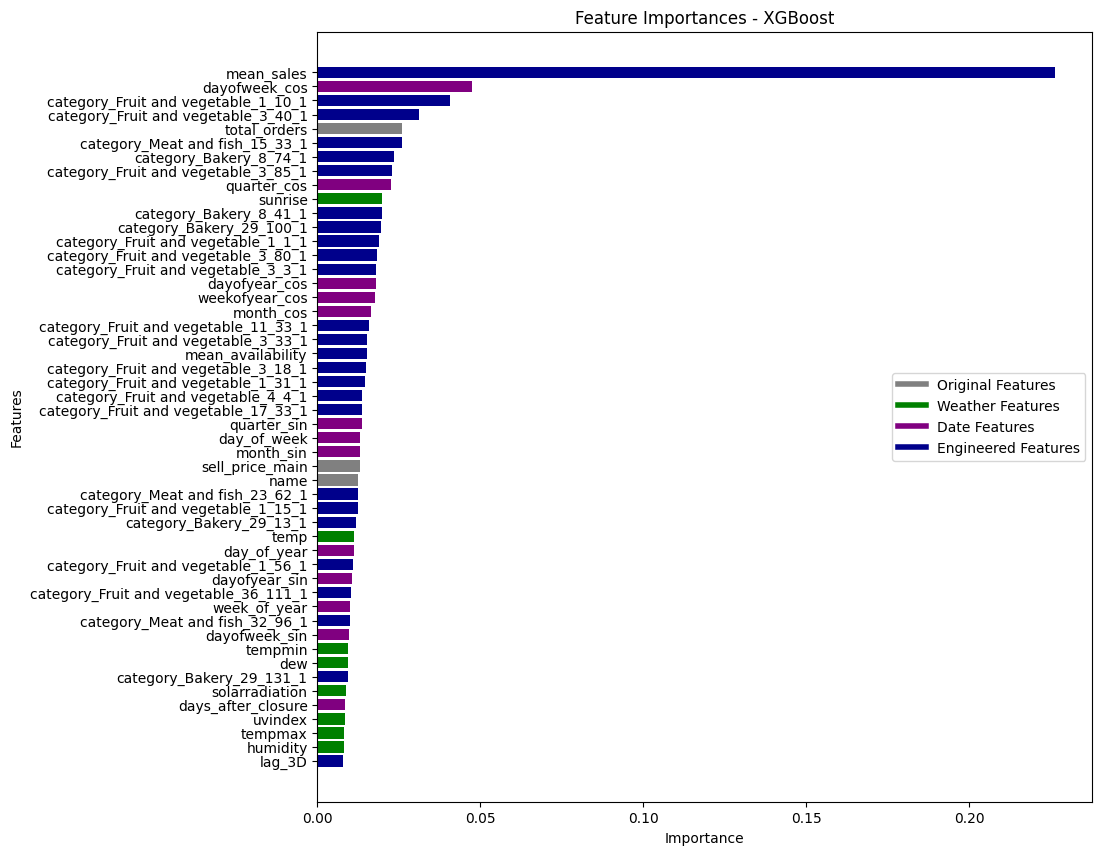

In [111]:
""" 
Feature importances
"""

# Get importance values
importances = xgb.feature_importances_

# Sort features by importance
sorted_indices = np.argsort(importances)[::-1]
sorted_features = X_train.columns[sorted_indices]
sorted_importances = importances[sorted_indices]

# Define feature categories
original_feat = list(sales_train.columns) + list(inventory.columns) + list(calendar.columns)
weather_feat = list(prague_weather.columns)
date_feat = [col for col in X_train.columns if any(word in col.lower() for word in ["day", "week", "month", "quarter", "year"])]
engineered_feat = [col for col in X_train.columns if col not in original_feat + weather_feat]


# Assign colors based on category
colors = []
for feature in sorted_features:
    if feature in original_feat:
        colors.append("grey")  # Original features
    elif feature in weather_feat:
        colors.append("green")  # Weather features
    elif feature in date_feat:
        colors.append("purple")  # Date-related features
    else:
        colors.append("darkblue")  # Engineered features

# Plot feature importance
plt.figure(figsize=(10, 10))
bars = plt.barh(range(len(sorted_importances)), sorted_importances, align="center", color=colors)
plt.yticks(range(len(sorted_importances)), sorted_features)
plt.xlabel("Importance")
plt.ylabel("Features")
plt.title("Feature Importances - XGBoost")
plt.gca().invert_yaxis()  # Show most important features on top

# Create a legend
plt.legend(
    handles=[
        plt.Line2D([0], [0], color="grey", lw=4, label="Original Features"),
        plt.Line2D([0], [0], color="green", lw=4, label="Weather Features"),
        plt.Line2D([0], [0], color="purple", lw=4, label="Date Features"),
        plt.Line2D([0], [0], color="darkblue", lw=4, label="Engineered Features"),
    ],
    loc="right",
)

plt.show()

In [ ]:
""" 
Feature Selection
"""
from sklearn.feature_selection import RFE

# Use Recursive Feature Elimination (RFE) to select top 50 features
# rfe = RFE(xgb, n_features_to_select=50)
# X_train_selected = rfe.fit_transform(X_train, y_train)
# X_val_selected = rfe.transform(X_val)  # Apply the same transformation to val data

# # Get the selected feature names
# selected_features = X_train.columns[rfe.support_]
# print("Selected Features:", selected_features.tolist())

# # Fit the model
# xgb.fit(X_train_selected , y_train,
#         eval_set=[(X_val_selected, y_val)],
#         verbose=True)

""" 
A quick test, keep commented if code above is enabled or selected features in place when training
"""
# X_train = X_train[sorted_features[:40]]
# X_val = X_val[sorted_features[:40]]

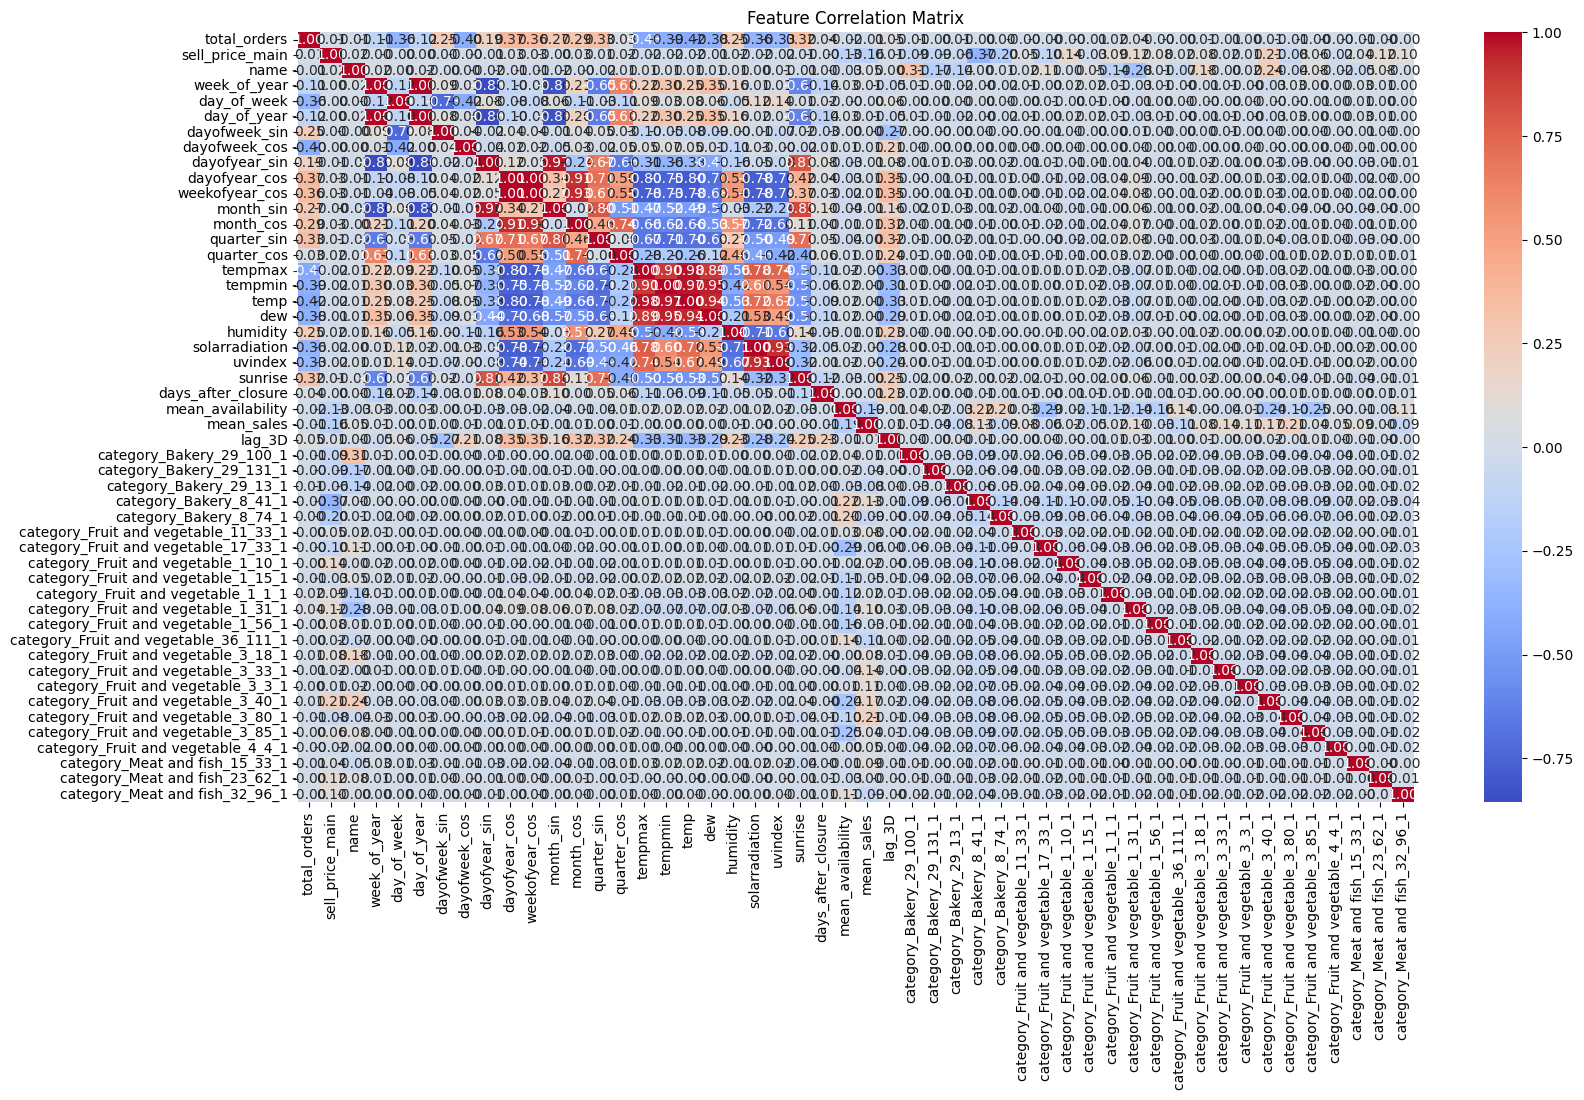

In [112]:
# Calculate correlation matrix
corr_matrix = X_train.corr()

# Plot heatmap
plt.figure(figsize=(18, 10))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Feature Correlation Matrix')
plt.show()

## **Hyperparameter Tuning with Optuna**

Best Parameters: {'n_estimators': 850, 'max_depth': 9, 'learning_rate': 0.02750640574303858, 'subsample': 0.7305515754606714, 'colsample_bytree': 0.7409045326437014, 'gamma': 0.8706592947373971, 'min_child_weight': 3, 'reg_lambda': 2.459685973721352, 'reg_alpha': 0.4470853320137403}
Best Score (MAE): 8.370600235320309

In [ ]:
# import optuna
# from xgboost import XGBRegressor
# from sklearn.model_selection import cross_val_score

# # Define the objective function for Optuna
# def objective(trial):
#     params = {
#         "n_estimators": trial.suggest_int("n_estimators", 100, 1000, step=50),
#         "max_depth": trial.suggest_int("max_depth", 6, 15, step=1),
#         "learning_rate": trial.suggest_float("learning_rate", 0.01, 0.1, log=True),
#         "subsample": trial.suggest_float("subsample", 0.7, 0.9),
#         "colsample_bytree": trial.suggest_float("colsample_bytree", 0.7, 0.9),
#         "gamma": trial.suggest_float("gamma", 0, 1),
#         "min_child_weight": trial.suggest_int("min_child_weight", 1, 5, step=2),
#         "reg_lambda": trial.suggest_float("reg_lambda", 1, 10),
#         "reg_alpha": trial.suggest_float("reg_alpha", 0, 1),
#         "objective": "reg:squarederror",
#         "tree_method": "hist"
#     }

#     # Initialize the model
#     model = XGBRegressor(**params)

#     # Perform 3-fold cross-validation and return the negative MAE
#     score = cross_val_score(model, X_train_selected, y_train, 
#                             scoring="neg_mean_absolute_error", cv=3, n_jobs=-1).mean()
    
#     return -score  # Optuna minimizes, so we negate MAE

# # Run Optuna optimization
# study = optuna.create_study(direction="minimize")
# study.optimize(objective, n_trials=50)  # Run 50 trials (adjust as needed)

# # Print best parameters
# print("Best Parameters:", study.best_params)
# print("Best Score (MAE):", study.best_value)

# **Results**

#| Model | MAE | Train R² | Test R² | Train RMSE | Test RMSE | Outliers Cleaned |Hyperparameter Tuning | RFE (N)
|:-:|:-:|:-:|:-:|:-:|:-:|:-:|:-:|:-:|:-:|
00 | XGBoost |14.83 | 0.95| 0.82 | 15.13| 29.96| No | No | No
01 | XGBoost | 8.21 | 0.86 | 0.71 | 7.48 | 11.10 | Yes | No | No
02 | XGBoost | 8.03 | 0.85 | 0.73 | 7.56 | 10.66 | Yes | No | Yes (50)
03 | XGBoost | 8.13 | 0.84 | 0.71 | 7.83 | 11.00 | Yes | No | Yes (40)
04 | XGBoost | 8.49 | 0.86 | 0.70 | 7.51 | 11.32 | Yes | No | Yes (60)
05 | XGBoost | 7.99 | 0.85 | 0.74 | 7.78 | 10.54 | Yes | Yes | Yes (50)